## Neural ODEs

In [50]:
%matplotlib inline
from typing import Optional, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torchdiffeq
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torchmetrics.classification import Accuracy

pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Global seed set to 42


Device: cpu


**Formulation**

The first-order ODE
$$
\begin{aligned}
\mathbf{\dot{y}}(t) = f(t, \mathbf{y}(t), \theta),\quad \mathbf{y}(t_0) = y_0,\quad f: \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n
\end{aligned}
$$
Our goal is to solve initial value problems (IVP), i.e. predict $\mathbf{y}(t_1)$ given $\mathbf{y}(t_0)$.
$$
\begin{aligned}
\mathbf{y}(t_1) &= \mathbf{y}(t_0) + \int_{t_0}^{t_1} f(\mathbf{y}(t), t, \theta) 
\mathrm{d}t \\ &= \textrm{ODESolve}(\mathbf{y}(t_0), f, t_0, t_1, \theta)
\end{aligned}
$$
Then using Euler's method to solve the ODE.

**Neural ODE**

However, for neural networks we have to backprop to train the network. After doing a forward pass we would have to back-propagate through the solver.
$$
\begin{aligned}
L(\mathbf{x}(t_1)) &= L\left(\mathbf{x}(t_0) + \int_{t_0}^{t_1} f(\mathbf{x}(t), t,
\theta) 
\mathrm{d}t\right) \\ &= L\left(\textrm{ODESolve}(\mathbf{x}(t_0), f, t_0, t_1, \theta)\right)
\end{aligned}
$$
To optimize $L$ we require gradients with respect to $\theta$. The problem is to efficiently calculate $\frac{\mathrm{d}L(\mathbf{x}(t_1))}{\mathrm{d}\theta}$ without storing all the function activations from the forward pass. There is a way using ``Adjoint methods'' to backpropagate.

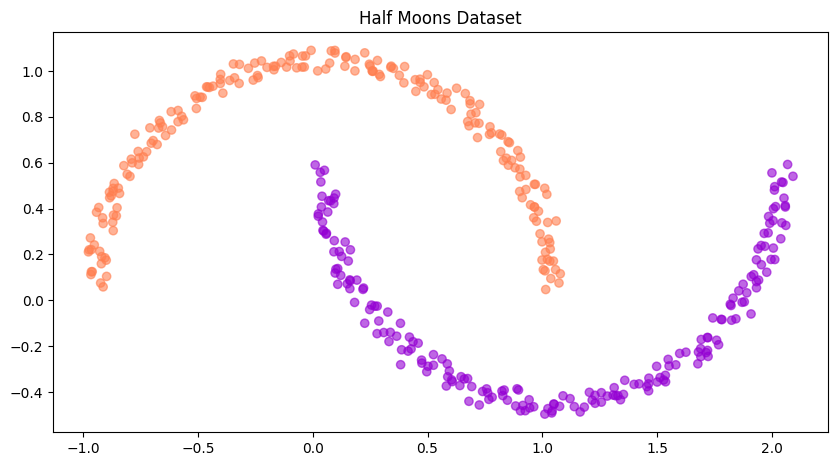

In [51]:
class MoonsDataset(Dataset):
    """Half Moons Classification Dataset

    Adapted from https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_moons(num_samples, noise_std)

    @staticmethod
    def generate_moons(num_samples=100, noise_std=1e-4):
        """Creates a *moons* dataset of `num_samples` data points.
        :param num_samples: number of data points in the generated dataset
        :type num_samples: int
        :param noise_std: standard deviation of noise magnitude added to each data point
        :type noise_std: float
        """
        num_samples_out = num_samples // 2
        num_samples_in = num_samples - num_samples_out
        theta_out = np.linspace(0, np.pi, num_samples_out)
        theta_in = np.linspace(0, np.pi, num_samples_in)
        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)
        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(num_samples_out), np.ones(num_samples_in)])

        if noise_std is not None:
            X += noise_std * np.random.rand(num_samples, 2)

        X = torch.Tensor(X)
        y = torch.LongTensor(y)
        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def plot_binary_classification_dataset(X, y, title=None):
    CLASS_COLORS = ['coral', 'darkviolet']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], color=[CLASS_COLORS[yi.int()] for yi in y], alpha=0.6)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

    return fig, ax

sample_dataset = MoonsDataset(num_samples=400, noise_std=1e-1)
fig, ax = plot_binary_classification_dataset(sample_dataset.X, sample_dataset.y, title='Half Moons Dataset')

In [52]:
def split_dataset(dataset_size:int, split_percentages:List[float]) -> List[int]:
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)
    return split_sizes


class ToyDataModule(pl.LightningDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__()
        self.dataset_size = dataset_size
        if split_percentages is None:
            split_percentages = [0.8, 0.1, 0.1]
        self.split_sizes = split_dataset(self.dataset_size, split_percentages)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        pass

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=len(self.train_set), shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_set, batch_size=len(self.val_set), shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=len(self.test_set), shuffle=False)
        return test_loader


class HalfMoonsDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)

    def setup(self, stage: Optional[str] = None):
        dataset = MoonsDataset(num_samples=self.dataset_size, noise_std=1e-1)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

Definition of Neural ODE model

In [53]:
class _ODEFunc(nn.Module):
    def __init__(self, module, autonomous=True):
        super().__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]]) * t, x], 1)
        return self.module(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, solver: str = 'dopri5',
                 rtol: float = 1e-4, atol: float = 1e-4, adjoint: bool = True,
                 autonomous: bool = True):
        super().__init__()
        self.odefunc = _ODEFunc(odefunc, autonomous=autonomous)
        self.rtol = rtol
        self.atol = atol
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32)

    @property
    def ode_method(self):
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        integration_time = self.integration_time if integration_time is None else integration_time
        integration_time = integration_time.to(x.device)
        ode_method =  torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time, rtol=self.rtol,
            atol=self.atol, method=self.solver)
        return out

# Lightning module
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, t_span:torch.Tensor, learning_rate:float=5e-3):
        super().__init__()
        self.model = model
        self.t_span = t_span
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def inference(self, x, time_span):
        return self.model(x, adjoint=False, integration_time=time_span)

    def inference_no_projection(self, x, time_span):
        return self.model.forward_no_projection(x, adjoint=False, integration_time=time_span)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('val_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

Finally, it is time to actually define a Neural ODE and train it. We will use a simple 2-layer MLP with a tanh activation and 64 hidden dimensions. We will train the model using the adjoint method for backpropagation.

In [54]:
adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)
trainer.fit(learner, datamodule=data_module)
val_result = trainer.validate(learner, datamodule=data_module, verbose=True)
test_result = trainer.test(learner, datamodule=data_module, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock           │    322 │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │
└───┴──────────┴────────────────────┴────────┘

Trainable params: 322                                                                                              
Non-trainable params: 0                                                                                            
Total params: 322                                                                                                  
Total estimated model params size (MB): 0

/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conn
ector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conn
ector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=200` reached.


/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   0.0021277095656841993   │
└───────────────────────────┴───────────────────────────┘

/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   0.0018282214878126979   │
└───────────────────────────┴───────────────────────────┘

/Users/robvangastel/miniconda3/envs/ode/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [55]:
@torch.no_grad()
def run_inference(learner, data_loader, time_span):
    learner.to(device)
    trajectories = []
    classes = []
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

time_span = np.linspace(0.0, 1.0, 100)
trajectories, classes = run_inference(learner, data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

Plot the trajectories in 2d:

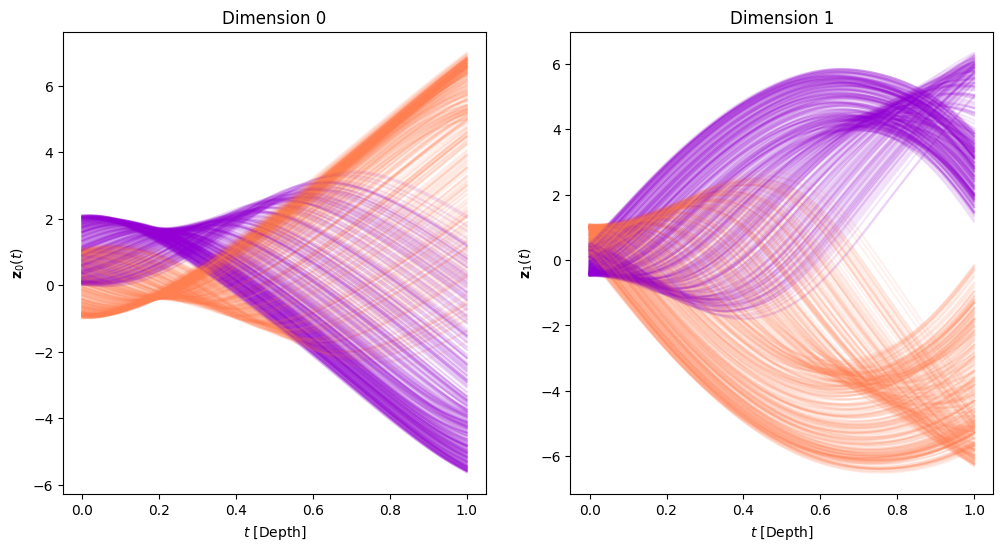

In [56]:
def plot_trajectories(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(trajectories.shape[1]):
        ax0.plot(time_span, trajectories[:, i, 0], color=class_colors[i], alpha=0.1)
        ax1.plot(time_span, trajectories[:, i, 1], color=class_colors[i], alpha=0.1)

    ax0.set_xlabel(r"$t$ [Depth]")
    ax0.set_ylabel(r"$\mathbf{z}_0(t)$")
    ax0.set_title("Dimension 0")
    ax1.set_xlabel(r"$t$ [Depth]")
    ax1.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax1.set_title("Dimension 1")

plot_trajectories(time_span, trajectories, class_colors)

The evolution of the 2 inputs dimensions as a function of time (depth) combined in one plot:

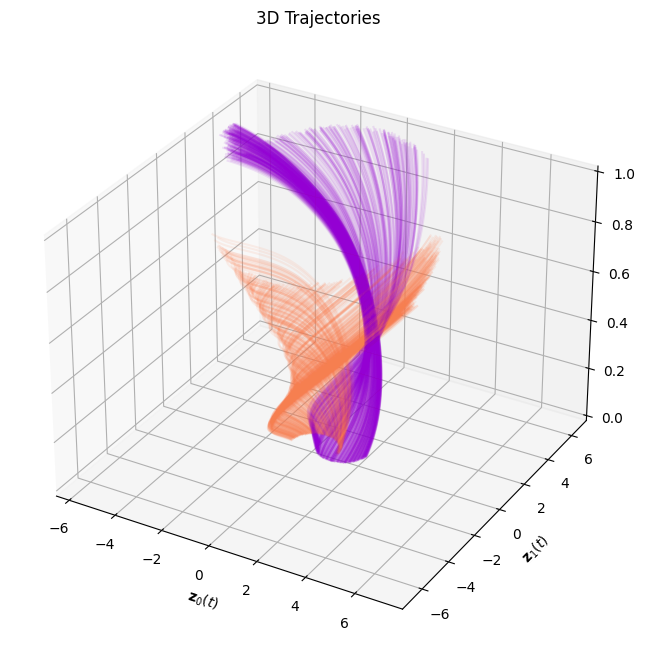

In [57]:
def plot_trajectories_3d(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], time_span,
                color=class_colors[i], alpha=0.1)

    ax.set_title('3D Trajectories')
    ax.set_xlabel(r"$\mathbf{z}_0(t)$")
    ax.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax.set_zlabel(r"$t$")

plot_trajectories_3d(time_span, trajectories, class_colors)

An animated version of the evolution. Each timestep of the animation is a slice on the temporal axis.

In [58]:
def plot_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim

anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

The state-space and learned vector field:

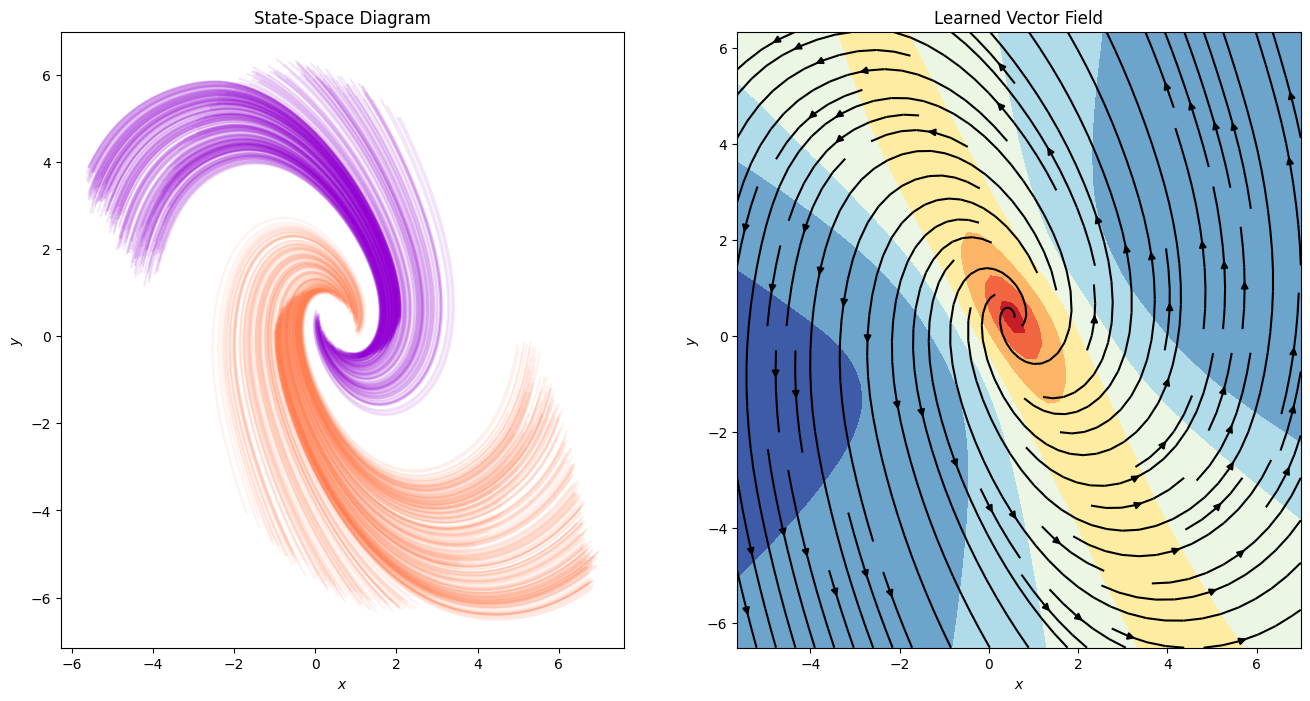

In [59]:
def plot_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


def plot_static_vector_field(model, trajectory, N=50, device='cpu', ax=None):
    X, Y = np.mgrid[trajectory[..., 0].min():trajectory[..., 0].max():N*1j,
                    trajectory[..., 1].min():trajectory[..., 1].max():N*1j]
    X = X.T
    Y = Y.T
    P = np.vstack([X.ravel(), Y.ravel()]).T
    P = torch.Tensor(P).to(device)

    with torch.no_grad():
        vector_field = model.odefunc(0.0, P).cpu()
    vector_norm = vector_field.norm(dim=1).view(N, N).numpy()

    vector_field = vector_field.view(N, N, 2).numpy()

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.contourf(X, Y, vector_norm, cmap='RdYlBu')
    ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title("Learned Vector Field")

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)